# Задача
одна из проблем, которую мы видим при обращении в саппорт - в разрезе разных категорий обращения необходимо смотреть в разные сервисы и собирать дополнительную информацию. На это уходит много времени. на одно обращение уходит в среднем 2 минуты поиска дополнительной информации. Стоимость часа работы сотрудника 6$.

Давайте поможем и оптимизируем время и деньги компании - сделаем модель,которая в зависимости от текста будет определять категорию обращения автоматически.

Тогда мы сможем сразу подготавливать информацию для наших операторов в течение 5 секунд (сбор и передача на фронт)

Нужно сделать модель многоклассовой классификации определения категории обращения

# загружаем данные

In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer

import datetime
import requests
import collections as co
import string
import re

import nltk
from nltk.tag import StanfordNERTagger
from sumy.utils import get_stop_words as gsw1
from stop_words import get_stop_words as gsw2


import pandas as pd
import numpy as np

In [2]:

from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import os
java_path = "C:/Program Files/Java/jre1.8.0_221/bin/java.exe"
os.environ['JAVAHOME'] = java_path

jar = 'C:/Course/xsolla/stanford-ner-4.0.0/stanford-ner-4.0.0.jar'
model = 'C:/Course/xsolla/stanford-ner-4.0.0/classifiers/english.all.3class.distsim.crf.ser.gz'

st = StanfordNERTagger(model, jar)


In [3]:
#df = pd.read_csv('./data/3categories_50.csv')
#df2 = pd.read_csv(r'C:\Users\22080\Downloads\4_notebooks\data\3categories_50.csv')
df = pd.read_csv(r'C:\Users\22080\Downloads\4_notebooks\data\3categories_50.csv')
df.shape

(50000, 3)

In [ ]:
df.head(2)

In [ ]:
df['category'].hist()

# Очитска от имён

In [ ]:
#text = 'chat transcript: visitor: i am attempting to verify my card however the payment is not posting. all charges typically post immediately with my bank. sofia: hello sofia: please stand by online, as it may take some time to resolve the issue. ill provide you with an update in a few minutes. thank you for your patience. '
text = df2.message[0]

def getNamesFromText(text):
    tag_list = []
    for sent in nltk.sent_tokenize(text):
        tokens = nltk.tokenize.word_tokenize(sent)
        tags = st.tag(tokens)
        print(tags)
        for tag in tags:
            if tag[1] in ["PERSON", "LOCATION", "ORGANIZATION"]:
                if tag[0] not in tag_list:
                    tag_list.append(tag[0])
    return tag_list
def getNamesFromDataFrame(df):
    df['NNP'] = df.apply(lambda row: getNamesFromText(row.message), axis=1)
    return df

df2['NNP'] = np.nan

for i in df2.index:
    df2['NNP'].iloc[i] = getNamesFromText(df2.iloc[i].message)


#df2 = getNamesFromDataFrame(df2)
df2.head()

In [ ]:
# extract ords from dataframe lists
names_list = []
for i in df2['NNP']:
    for j in i:
        if j not in names_list:
            names_list.append(j)
names_list


In [ ]:
def clearTextAfterGarbage(Corpus,Substr):
    clear_corpus = []
    for text in Corpus:
        indexes = []
        text_len = len(text)
        try:
            for i in range(0,text_len):
                res = re.search(Substr,text[i])
                if res != None:
                    indexes.append(i)
                
            #delete garbage word from text
            for index in indexes:
                del text[index]
        
            clear_corpus.append(text)
        except:
            #clear_corpus.append("error")
            clear_corpus.append(text) # а то слишком много ошибок
        
    return clear_corpus

def clearTextAfterGarbageList2(Corpus,Garbage):
    clear_corpus = Corpus
    for Substr in Garbage:
        clear_corpus = clearTextAfterGarbage(clear_corpus,Substr)
    return clear_corpus

In [ ]:
df2.message = clearTextAfterGarbageList2(df2.message, names_list)

# прежде всего очистка данных

In [ ]:
#убираем технические данные в сообщениях и прочий шум
df['message'] = df['message'].str.replace('\[.*\]', '', regex=True)

df['message'] = df['message'].str.replace("\!", '', regex=True)
df['message'] = df['message'].str.replace("\'", '', regex=True)

df['message'] = df['message'].str.replace("[^A-Za-z0-9^,!.\/'+-=]", ' ', regex=True)


In [ ]:
#переведем в нижний регистр
df['message'] = df['message'].str.replace("\s+", ' ', regex=True)
df['message'] = df['message'].str.lower()

In [ ]:
#уберем шум
df.dropna(inplace = True)
df.shape

In [ ]:
# уберем шумовые длинные сообщения
df['message_len'] = df['message'].str.len()

df = df[(df['message_len'] < np.percentile(df.message_len,99))][:]

df.shape

# очистим весь наш текст от шумовых слов и преобразуем к первообразным формам


In [4]:
#давайте попробуем очистить от шума наши сообщения и создадим новый текст очищенный от мусора

In [5]:
df_reviews = df[['message']][:]
df_reviews.columns = ['review']
df_reviews.reset_index(drop = True , inplace = True)
df_reviews.head(2)

,review
0,\nChat transcript:\nVisitor: I am attempting t...
1,\nChat transcript:\nVisitor: Hi. For some reas...


In [6]:

list_count_words = []
list_true_words = []
list_tagged = []
list_tags = []

for i ,row in  df_reviews.iterrows():
    words = []
    tagged = []
    true_words = []
    tags = []
    
    a_line = row['review']

    
    try:
        words = re.split(' ', a_line)
        true_words = []

        for word in words:
            m = re.search('(\w+)',word)
            if m is not None:
                good_word = m.group(0)
                true_words.append(good_word)

        tagged = nltk.pos_tag(true_words)
        tags = []
        for tag in tagged:
            tags.append(tag[1])
    except:
        pass



    list_count_words.append(len(words))   
    list_tagged.append(tagged)
    list_true_words.append(true_words)
    list_tags.append(tags)


In [7]:
df_reviews['count_words'] = list_count_words
df_reviews['list_of_words'] = list_true_words

df_reviews['list_of_tags'] = list_tags
df_reviews['word_with_tag_list'] = list_tagged


In [8]:
text_analizator_df = df_reviews[:]
text_analizator_df.rename(columns = {'review' : 'sentence'} , inplace = True)
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list
0,\nChat transcript:\nVisitor: I am attempting t...,71,"[Chat, transcript, I, am, attempting, to, veri...","[NNP, NN, PRP, VBP, VBG, TO, VB, PRP$, NN, RB,...","[(Chat, NNP), (transcript, NN), (I, PRP), (am,..."
1,\nChat transcript:\nVisitor: Hi. For some reas...,101,"[Chat, transcript, Hi, For, some, reason, it, ...","[NNP, VBZ, NNP, IN, DT, NN, PRP, VBZ, IN, PRP$...","[(Chat, NNP), (transcript, VBZ), (Hi, NNP), (F..."
2,"\nChat transcript:\nVisitor: Здравствуйте, я х...",98,"[Chat, transcript, Здравствуйте, я, хотел, опл...","[NNP, NN, NNP, NNP, NNP, NNP, NNP, NNP, NNP, N...","[(Chat, NNP), (transcript, NN), (Здравствуйте,..."
3,\nChat transcript:\nVisitor: no puedo hacer la...,138,"[Chat, transcript, no, puedo, hacer, la, recar...","[NNP, VBZ, DT, JJ, NN, NN, FW, FW, NN, NNP, NN...","[(Chat, NNP), (transcript, VBZ), (no, DT), (pu..."
4,\nChat transcript:\nVisitor: hi im trying to b...,99,"[Chat, transcript, hi, im, trying, to, buy, bi...","[NNP, NN, NN, NN, VBG, TO, VB, NNS, CC, PRP, V...","[(Chat, NNP), (transcript, NN), (hi, NN), (im,..."


In [9]:
#получили новое смысловое описание атрибутов текста, видно много местоимений и другой информации, давайте очистим

In [10]:
stopWords =nltk.corpus.stopwords.words()

LANGUAGE = 'english'

sw0 = ["yeah","zola","don"]
sw1 = gsw1(LANGUAGE)
sw2 = gsw2('en')

sw0.extend(list(sw1))
sw0.extend(list(sw2))



new_s_list = []
new_lw_list = []
new_lt_list = []
new_lwt_list = []
new_count_words = []

for s , lw , lt ,lwt in zip (text_analizator_df['sentence'] 
                        , text_analizator_df['list_of_words'] 
                        , text_analizator_df['list_of_tags']
                        , text_analizator_df['word_with_tag_list']):
    new_s = ''
    new_lw = []
    new_lt = []
    new_lwt = []
    for w,t,lw in zip(lw,lt,lwt):
        if t in ['NN','VB','DT','NNS','VBP','VB']:
            new_s += w + ' '
            new_lw.append(w)
            new_lt.append(t)
            new_lwt.append(lw)
        elif w in sw0 or re.match('\d+',w) is not None:
            continue

    
    new_s_list.append(new_s)
    new_lw_list.append(new_lw)
    new_lt_list.append(new_lt)
    new_lwt_list.append(new_lwt)
    new_count_words.append(len(new_lw))
        
text_analizator_df['new_sentence'] = new_s_list
text_analizator_df['list_of_words'] = new_lw_list
text_analizator_df['list_of_tags'] = new_lt_list
text_analizator_df['word_with_tag_list'] = new_lwt_list
text_analizator_df['count_words'] = new_count_words


In [11]:
# в итоге выделив основные главне слова, которые нам могут быть интересны потенциально
# получили new_sentence, можнте посмотреть как он отличается
print(f'old- {text_analizator_df.loc[0]["sentence"]}' )
print('\n')
print(f'new -{text_analizator_df.loc[0]["new_sentence"]}' )

old- 
Chat transcript:
Visitor: I am attempting to verify my card however the payment is not posting. All charges typically post immediately with my bank.
Sofia: Hello!
Sofia: Please stand by online, as it may take some time to resolve the issue. I'll provide you with an update in a few minutes. Thank you for your patience.
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]


new -transcript am verify card the payment All charges post bank stand online take some time resolve the issue provide an update a minutes Thank patience page https page https page https 


In [12]:
text_analizator_df.head()

,sentence,count_words,list_of_words,list_of_tags,word_with_tag_list,new_sentence
0,\nChat transcript:\nVisitor: I am attempting t...,31,"[transcript, am, verify, card, the, payment, A...","[NN, VBP, VB, NN, DT, NN, DT, NNS, VBP, NN, VB...","[(transcript, NN), (am, VBP), (verify, VB), (c...",transcript am verify card the payment All char...
1,\nChat transcript:\nVisitor: Hi. For some reas...,45,"[some, reason, prepcoin_nl, didn, go, thru, a,...","[DT, NN, NN, NN, VBP, NN, DT, NN, NN, DT, NN, ...","[(some, DT), (reason, NN), (prepcoin_nl, NN), ...",some reason prepcoin_nl didn go thru a receipt...
2,"\nChat transcript:\nVisitor: Здравствуйте, я х...",13,"[transcript, pay, a, subscription, the, platfo...","[NN, VB, DT, NN, DT, NN, DT, NNS, NN, DT, NN, ...","[(transcript, NN), (pay, VB), (a, DT), (subscr...",transcript pay a subscription the platform the...
3,\nChat transcript:\nVisitor: no puedo hacer la...,63,"[no, hacer, la, cash, no, hablo, así, ire, tra...","[DT, NN, NN, NN, DT, NN, NN, NN, NN, NN, NN, N...","[(no, DT), (hacer, NN), (la, NN), (cash, NN), ...",no hacer la cash no hablo así ire traductor pa...
4,\nChat transcript:\nVisitor: hi im trying to b...,41,"[transcript, hi, im, buy, bits, payment, be, a...","[NN, NN, NN, VB, NNS, NN, VB, VB, DT, NN, NN, ...","[(transcript, NN), (hi, NN), (im, NN), (buy, V...",transcript hi im buy bits payment be address t...


In [13]:
text_analizator_df = text_analizator_df.iloc[0:15000]

# генерация вектора
Давайте попробуем оставить только важные слова

In [14]:
text_analizator_df['text_arr'] = text_analizator_df.new_sentence.str.split('\W+').tolist()

In [15]:
#сделаем массив из всех слов, разделенных пробелами, которые могут встречаться
text_arrays = text_analizator_df['text_arr'].tolist()
text_arrays = np.concatenate( text_arrays, axis=0 )


In [16]:
#уберем все пустые строки
text_arrays = list( text_arrays)
text_arrays = list(filter(None, text_arrays))

Text(0.5, 1.0, 'Top Words')

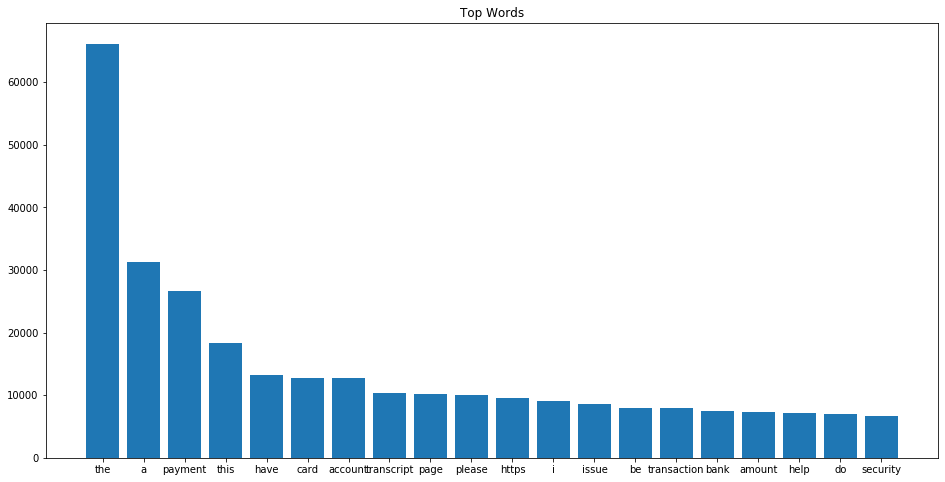

In [17]:
#проанализируем популярные слова
from sklearn.feature_extraction.text import CountVectorizer

c_text = co.Counter(text_arrays)

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(20):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [18]:
#посмотрим непопулярные слова мало ли там беда
pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0).head(15)

#видно в непопулярных словах какой то треш, они явно бесполезны при создании нашей модели, идем верно

,0
Precommand,1
aufladen,1
uu,1
cmontiel29,1
paganent,1
nothin,1
traves,1
vindictus,1
мегафон,1
Киви,1


# стемминг
важной частью задач nlp является преобразование к первоначальной форме, т.к. мы сужаем область поиска для слов

In [19]:
text_analizator_df['text_arr'] = text_analizator_df.new_sentence.str.split('\W+').tolist()

In [20]:
from nltk.stem.porter import *
stemming = PorterStemmer()

def stem_list(row):
    my_list = row['text_arr']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

text_analizator_df['stem_arr'] = text_analizator_df.apply(stem_list, axis=1)


In [21]:
text_arrays = text_analizator_df['stem_arr'].tolist()
text_arrays = np.concatenate( text_arrays, axis=0 )


Text(0.5, 1.0, 'Top Words')

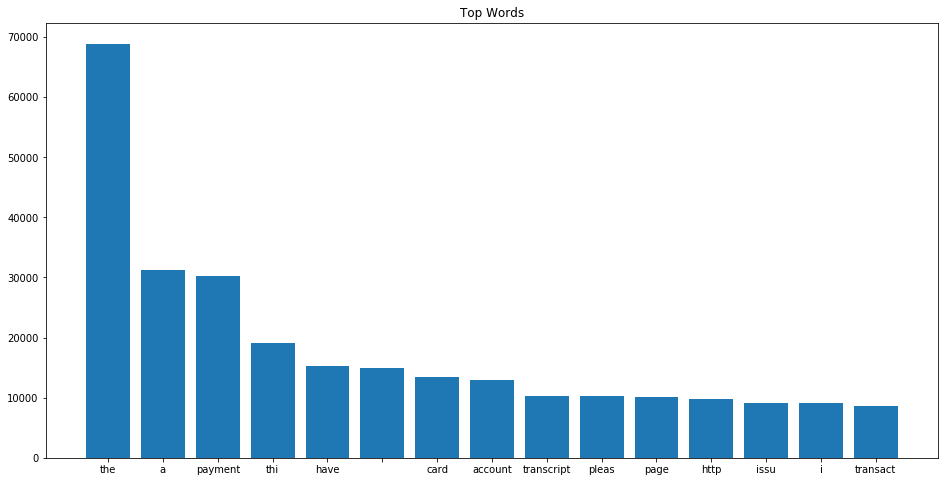

In [22]:
#отлично видим что наши частовстречающиеся слова однородны
c_text = co.Counter(text_arrays)

w =[]
count_w = []


most_freq_words = []

for i in c_text.most_common(15):
    w.append(i[0])
    count_w.append(i[1])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(w)), count_w)
ax.set_xticks(range(len(w)))
ax.set_xticklabels(w)
ax.set_title('Top Words')

In [23]:
# мы хотим попробовать подход tf-idf над словами, для того, чтобы веса были равномерны - давайте выберем наиболее корректные слова
#top_words = 1500 # old, accuracy 0,48
top_words = 1000 # new
pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0,ascending = False).head(top_words)

,0
the,68898
a,31232
payment,30244
thi,19154
have,15280
...,...
ai,39
procedur,39
başka,39
avec,39


In [24]:
#оставим для модели топ слов
final_words = pd.DataFrame.from_dict(dict(c_text) , orient = 'index').sort_values(by = 0 , ascending = False).head(top_words).index.values

In [25]:
f = lambda x: ' '.join([item for item in x if item in final_words])
text_analizator_df['stem_text'] = text_analizator_df['stem_arr'].apply(f)

In [26]:
# в итоге выделив основные главные слова, которые нам могут быть интересны потенциально
# получили new_sentence, можнте посмотреть как он отличается
print(f'old- {text_analizator_df.loc[0]["sentence"]}' )
print('\n')
print(f'new -{text_analizator_df.loc[0]["new_sentence"]}' )
print('\n')
print(f'stem -{text_analizator_df.loc[0]["stem_text"]}' )

old- 
Chat transcript:
Visitor: I am attempting to verify my card however the payment is not posting. All charges typically post immediately with my bank.
Sofia: Hello!
Sofia: Please stand by online, as it may take some time to resolve the issue. I'll provide you with an update in a few minutes. Thank you for your patience.
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]
[Visitor page reloaded. New URL: https://secure.xsolla.com/paystation3/?access_token=vlp0QhPAE54cVIsykIWwTE0BZp70mAQy ]


new -transcript am verify card the payment All charges post bank stand online take some time resolve the issue provide an update a minutes Thank patience page https page https page https 


stem -transcript am verifi card the payment all charg post bank stand onlin take some time resolv the issu provid an updat

# сделаем теперь векторное представление

In [27]:
#ну тут без особой магии
texts = df['message']
texts = text_analizator_df['sentence']
texts = text_analizator_df['stem_text']

vec = TfidfVectorizer(max_features=top_words)
tfidf_mat = vec.fit_transform(texts).toarray()
print(type(tfidf_mat),tfidf_mat.shape)
#на выход получаем матрицу заданной размерности

<class 'numpy.ndarray'> (15000, 973)


# выравнивание классов

In [28]:
train = pd.DataFrame(tfidf_mat)
train['category'] =  df['category']

target = 'category'
train_columns = list(set(train.columns) - set([target]))

train.head()

,0,1,2,3,4,5,6,7,8,9,...,964,965,966,967,968,969,970,971,972,category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs
1,0.0,0.0,0.0,0.0,0.0,0.0,0.258281,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,other
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.448594,0.0,0.0,afs
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142422,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs


In [29]:
train.dropna(inplace = True)

In [30]:
#переводим в инты таргет
labels, levels = pd.factorize(train[target])
train['category_int'] = labels

target = train['category_int']

In [31]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,965,966,967,968,969,970,971,972,category,category_int
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.258281,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,other,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.448594,0.0,0.0,afs,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142422,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,afs,0


In [32]:
train[(train['category_int'] == -1)]
train.category.unique()

array(['afs', 'other', 'ps'], dtype=object)

In [33]:
#train[target].value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
'''#сделаем оверсемплинг

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(train[train_columns], train[target])

print(f'rate target detect fight in game {sum(y_ros) / X_ros.shape[0]}')

y_ros.value_counts().plot(kind='bar', title='Count (target)');'''

In [ ]:
'''X_ros[target] = y_ros
train = X_ros[:]'''

In [ ]:
'''train = train.iloc[:15000, :]
train.info()'''

In [63]:
train["category_int"]

0        0
1        1
2        0
3        0
4        0
        ..
14995    0
14996    0
14997    0
14998    0
14999    0
Name: category_int, Length: 15000, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split
train2 = train.iloc[:5000, :]
x_train, x_test, y_train, y_test = train_test_split(train[train_columns],
                                                       train["category_int"],
                                                       test_size=0.2,
                                                      random_state=22031990
                                                        #,stratify = train2[target]
                                                       )
    
print(f'Train set: {x_train.shape[0]} size , {sum(y_train) / x_train.shape[0]} target size')
print(f'Test set: {x_test.shape[0]} size , {sum(y_test) / x_test.shape[0]} target size')

Train set: 12000 size , 0.42141666666666666 target size
Test set: 3000 size , 0.425 target size


In [65]:
x_train.to_csv("D:/Зубарев (D)/Python/x_train.csv")
x_test.to_csv("D:/Зубарев (D)/Python/x_test.csv")
y_train.to_csv("D:/Зубарев (D)/Python/y_train.csv")
y_test.to_csv("D:/Зубарев (D)/Python/y_test.csv")

In [58]:
x_train[train_columns].head()

,0,1,2,3,4,5,6,7,8,9,...,963,964,965,966,967,968,969,970,971,972
7881,0.0,0.0,0.0,0.0,0.0,0.0,0.201820,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9388,0.0,0.0,0.0,0.0,0.0,0.0,0.211037,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
12501,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1591,0.0,0.0,0.0,0.0,0.0,0.0,0.124161,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8929,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.446829,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,963,964,965,966,967,968,969,970,971,972
778,0.0,0.0,0.0,0.0,0.0,0.0,0.159762,0.0,0.126751,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10924,0.0,0.0,0.0,0.0,0.0,0.0,0.153336,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10524,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4715,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
y_train.head()

,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
y_test.head()

,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# наконец переходим к модели

In [48]:
from sklearn.neural_network import MLPClassifier
TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)

In [66]:
TextClassifier.fit(x_train[train_columns],y_train)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=40)

In [68]:
pred = TextClassifier.predict(x_test)

In [70]:
y_test

778      0
10924    1
3527     1
10524    0
4715     0
        ..
4428     0
497      0
6277     1
3435     0
7814     1
Name: category_int, Length: 3000, dtype: int64

TypeError: cannot unpack non-iterable ConfusionMatrixDisplay object

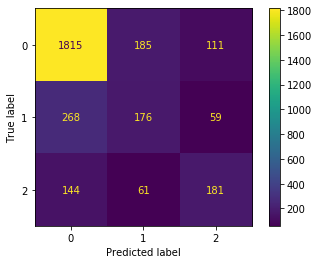

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

cm = confusion_matrix(y_true=y_test,
                      y_pred=pred)

fig, ax = plot_confusion_matrix(TextClassifier, x_test, y_test)

#ig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)
plt.show()

In [ ]:
df.category.hist()

In [ ]:
plt.hist(TextClassifier.predict(pd.DataFrame(tfidf_mat)))

# Сохраняем модель

In [41]:
import pickle 
#vec = TfidfVectorizer(max_features=top_words)
#tfidf_mat = vec.fit_transform(texts).toarray()
pickle.dump(vec, open(r"D:/Зубарев (D)/Python/tfidf.pickle", "wb"))

In [ ]:
#TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)
#TextClassifier.fit(x_train[train_columns],y_train)

In [67]:
pickle.dump(TextClassifier, open("D:/Зубарев (D)/Python/MLPClassifier_model.pickle", "wb"))

In [ ]:
TextClassifier2 = pickle.load(open("C:/Course/xsolla/MLPClassifier_model.pickle", "rb"))
pred2 = TextClassifier2.predict(x_test)
cm = confusion_matrix(y_target=y_target,
                      y_predicted=pred2)

fig, ax = plot_confusion_matrix(conf_mat=cm)

ig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
#fig.savefig('test2png.png', dpi=100)
plt.show()

In [ ]:
pred2_proba = TextClassifier2.predict_proba(x_test)
pred2_proba

In [ ]:
#from joblib import dump, load
#dump(TextClassifier, 'C:/Course/xsolla/MLPClassifier_model.joblib')
